In [1]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from abm.spatial_compartmental.utils import calc_start_n_initial,Neighbourhood
from abm.spatial_compartmental.sir import get_abm
from functools import partial
from flax import nnx
from checkpointing import CheckPointer
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from surrogate.diffusion.denoiser import Denoiser, DenoiserConfig, SigmaDistributionConfig, map_image_to_palette
from surrogate.diffusion.diffusion_sampler import DiffusionSampler, DiffusionSamplerConfig

# Setup/Utils

In [ ]:
rgb_colours = jnp.array([[0,0,0], [0,0,1], [1,0,0],[0,1,0]]).astype(jnp.float32)
abm = get_abm(Neighbourhood.VONNEUMANN, vmap=True)
def map_batch_grid_series_to_rgb(x):
    #B, T, C, H, W
    rgb_colours = jnp.array([[0,0,0], [0,0,1], [1,0,0],[0,1,0]]).astype(jnp.float32)
    indexed_x  = 2*x[:,:,0,:,:] + x[:,:,1,:,:] + 3*x[:,:,2,:,:]
    return rgb_colours[indexed_x]
def vectorized_abm_state_counts_jax(abm_grids_batch):
    """
    Calculates state counts for a batch of ABM grids using JAX.
    
    Args:
        abm_grids_batch (jnp.ndarray): An array of shape (batch_size, 3, 5, 5)
                                       representing all grids at a single time step.
                                      
    Returns:
        dict: A dictionary where keys are state names (str) and values are
              JAX arrays (shape (batch_size,)) containing the counts of that
              state for each grid in the batch.
    """
    counts = {}
    # Unoccupied: (layer0==0) & (layer1==0) & (layer2==0)
    counts["Unoccupied"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 0) & \
        (abm_grids_batch[:, 1, :, :] == 0) & \
        (abm_grids_batch[:, 2, :, :] == 0),
        axis=(1, 2) # Sum over the 5x5 grid dimensions
    ).astype(jnp.int32) # Ensure integer counts
    
    # Susceptible: (layer0==0) & (layer1==1) & (layer2==0)
    counts["Susceptible"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 0) & \
        (abm_grids_batch[:, 1, :, :] == 1) & \
        (abm_grids_batch[:, 2, :, :] == 0),
        axis=(1, 2)
    ).astype(jnp.int32)
    
    # Infected: (layer0==1) & (layer1==0) & (layer2==0)
    counts["Infected"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 1) & \
        (abm_grids_batch[:, 1, :, :] == 0) & \
        (abm_grids_batch[:, 2, :, :] == 0),
        axis=(1, 2)
    ).astype(jnp.int32)
    
    # Recovered: (layer0==0) & (layer1==0) & (layer2==1)
    counts["Recovered"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 0) & \
        (abm_grids_batch[:, 1, :, :] == 0) & \
        (abm_grids_batch[:, 2, :, :] == 1),
        axis=(1, 2)
    ).astype(jnp.int32)
    return counts

def process_grid_time_series_jax(data, 
                                 percentiles_to_calc=[2.5, 50, 97.5], 
                                 normalization_factor=None):
    """
    Processes a batch of ABM grid time series using JAX to calculate 
    statistics for each state over time. Optionally normalizes counts by a user-provided factor.

    Args:
        data (jnp.ndarray or np.ndarray): The input data of shape 
                                     (batch_size, sequence_length, num_layers, H, W).
        percentiles_to_calc (list): A list of percentiles to calculate (e.g., [25, 50, 75]).
        normalization_factor (Optional[Union[int, float]]): If provided as a number 
                                 (int or float), all state counts will be divided by this 
                                 factor before calculating statistics. Division by zero will result 
                                 in `inf` or `nan` values. Negative factors will change the sign.
                                 If None, raw counts are used. Non-numeric, non-None types 
                                 will raise a TypeError. Defaults to None.
                           
    Returns:
        dict: A dictionary where keys are state names. Each state name maps to
              another dictionary where keys are statistic names (e.g., "mean", "p25")
              and values are Python lists representing the time series of that statistic.
    """
    if not isinstance(data, jnp.ndarray):
        data = jnp.array(data)

    batch_size, sequence_length, num_layers, H, W = data.shape
    state_keys = ["Unoccupied", "Susceptible", "Infected", "Recovered"]

    if batch_size == 0 or sequence_length == 0:
        print(f"Warning: Batch size ({batch_size}) or sequence length ({sequence_length}) is 0. Returning empty results.")
        stats_names_empty = ["mean"] + [f"p{p}" for p in percentiles_to_calc]
        return {
            state: {stat_name: [] for stat_name in stats_names_empty}
            for state in state_keys
        }

    perform_normalization = False
    actual_normalization_factor = None # Stores the float version of the factor

    if normalization_factor is not None:
        if not isinstance(normalization_factor, (int, float)):
            raise TypeError(
                f"normalization_factor must be a number (int or float) or None. "
                f"Got type: {type(normalization_factor)} with value: {normalization_factor}"
            )
        perform_normalization = True
        actual_normalization_factor = float(normalization_factor)

    stats_names = ["mean"] + [f"p{p}" for p in percentiles_to_calc]
    time_series_stats = {
        state: {stat_name: [] for stat_name in stats_names}
        for state in state_keys
    }

    jnp_percentiles_q = jnp.array(percentiles_to_calc, dtype=jnp.float32)

    for t in range(sequence_length):
        grids_at_timestep_t = data[:, t, :, :, :]
        current_batch_summaries = vectorized_abm_state_counts_jax(grids_at_timestep_t)
        
        for state_key in state_keys:
            counts_for_state_across_batch = current_batch_summaries[state_key]
            
            if perform_normalization:
                # Normalize by the user-provided factor.
                # JAX will handle division by zero (-> inf/nan) or negative factors.
                counts_for_state_across_batch = counts_for_state_across_batch.astype(jnp.float32) / actual_normalization_factor
            
            mean_val = jnp.mean(counts_for_state_across_batch).item()
            time_series_stats[state_key]["mean"].append(mean_val)
            
            calculated_percentiles = jnp.percentile(counts_for_state_across_batch, q=jnp_percentiles_q)
            
            if jnp_percentiles_q.ndim == 0:
                calculated_percentiles_items = [calculated_percentiles.item()]
            else:
                calculated_percentiles_items = [p.item() for p in calculated_percentiles]

            for i, p_val in enumerate(percentiles_to_calc):
                time_series_stats[state_key][f"p{p_val}"].append(calculated_percentiles_items[i])
                
    return time_series_stats

def rgb_vectorized_abm_state_counts_jax(abm_grids_batch):
    """
    Calculates state counts for a batch of ABM grids using JAX.
    
    Args:
        abm_grids_batch (jnp.ndarray): An array of shape (batch_size, 3, 5, 5)
                                       representing all grids at a single time step.
                                      
    Returns:
        dict: A dictionary where keys are state names (str) and values are
              JAX arrays (shape (batch_size,)) containing the counts of that
              state for each grid in the batch.
    """
    counts = {}
    # Unoccupied: (layer0==0) & (layer1==0) & (layer2==0)
    counts["Unoccupied"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 0) & \
        (abm_grids_batch[:, 1, :, :] == 0) & \
        (abm_grids_batch[:, 2, :, :] == 0),
        axis=(1, 2) # Sum over the 5x5 grid dimensions
    ).astype(jnp.int32) # Ensure integer counts
    
    # Susceptible: (layer0==0) & (layer1==1) & (layer2==0)
    counts["Susceptible"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 0) & \
        (abm_grids_batch[:, 1, :, :] == 0) & \
        (abm_grids_batch[:, 2, :, :] == 1),
        axis=(1, 2)
    ).astype(jnp.int32)
    
    # Infected: (layer0==1) & (layer1==0) & (layer2==0)
    counts["Infected"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 1) & \
        (abm_grids_batch[:, 1, :, :] == 0) & \
        (abm_grids_batch[:, 2, :, :] == 0),
        axis=(1, 2)
    ).astype(jnp.int32)
    
    # Recovered: (layer0==0) & (layer1==0) & (layer2==1)
    counts["Recovered"] = jnp.sum(
        (abm_grids_batch[:, 0, :, :] == 0) & \
        (abm_grids_batch[:, 1, :, :] == 1) & \
        (abm_grids_batch[:, 2, :, :] == 0),
        axis=(1, 2)
    ).astype(jnp.int32)
    return counts

def rgb_process_grid_time_series_jax(data, 
                                 percentiles_to_calc=[2.5, 50, 97.5], 
                                 normalization_factor=None):
    """
    Processes a batch of ABM grid time series using JAX to calculate 
    statistics for each state over time. Optionally normalizes counts by a user-provided factor.

    Args:
        data (jnp.ndarray or np.ndarray): The input data of shape 
                                     (batch_size, sequence_length, num_layers, H, W).
        percentiles_to_calc (list): A list of percentiles to calculate (e.g., [25, 50, 75]).
        normalization_factor (Optional[Union[int, float]]): If provided as a number 
                                 (int or float), all state counts will be divided by this 
                                 factor before calculating statistics. Division by zero will result 
                                 in `inf` or `nan` values. Negative factors will change the sign.
                                 If None, raw counts are used. Non-numeric, non-None types 
                                 will raise a TypeError. Defaults to None.
                           
    Returns:
        dict: A dictionary where keys are state names. Each state name maps to
              another dictionary where keys are statistic names (e.g., "mean", "p25")
              and values are Python lists representing the time series of that statistic.
    """
    if not isinstance(data, jnp.ndarray):
        data = jnp.array(data)

    batch_size, sequence_length, num_layers, H, W = data.shape
    state_keys = ["Unoccupied", "Susceptible", "Infected", "Recovered"]

    if batch_size == 0 or sequence_length == 0:
        print(f"Warning: Batch size ({batch_size}) or sequence length ({sequence_length}) is 0. Returning empty results.")
        stats_names_empty = ["mean"] + [f"p{p}" for p in percentiles_to_calc]
        return {
            state: {stat_name: [] for stat_name in stats_names_empty}
            for state in state_keys
        }

    perform_normalization = False
    actual_normalization_factor = None # Stores the float version of the factor

    if normalization_factor is not None:
        if not isinstance(normalization_factor, (int, float)):
            raise TypeError(
                f"normalization_factor must be a number (int or float) or None. "
                f"Got type: {type(normalization_factor)} with value: {normalization_factor}"
            )
        perform_normalization = True
        actual_normalization_factor = float(normalization_factor)

    stats_names = ["mean"] + [f"p{p}" for p in percentiles_to_calc]
    time_series_stats = {
        state: {stat_name: [] for stat_name in stats_names}
        for state in state_keys
    }

    jnp_percentiles_q = jnp.array(percentiles_to_calc, dtype=jnp.float32)

    for t in range(sequence_length):
        grids_at_timestep_t = data[:, t, :, :, :]
        current_batch_summaries = rgb_vectorized_abm_state_counts_jax(grids_at_timestep_t)
        
        for state_key in state_keys:
            counts_for_state_across_batch = current_batch_summaries[state_key]
            
            if perform_normalization:
                # Normalize by the user-provided factor.
                # JAX will handle division by zero (-> inf/nan) or negative factors.
                counts_for_state_across_batch = counts_for_state_across_batch.astype(jnp.float32) / actual_normalization_factor
            
            mean_val = jnp.mean(counts_for_state_across_batch).item()
            time_series_stats[state_key]["mean"].append(mean_val)
            
            calculated_percentiles = jnp.percentile(counts_for_state_across_batch, q=jnp_percentiles_q)
            
            if jnp_percentiles_q.ndim == 0:
                calculated_percentiles_items = [calculated_percentiles.item()]
            else:
                calculated_percentiles_items = [p.item() for p in calculated_percentiles]

            for i, p_val in enumerate(percentiles_to_calc):
                time_series_stats[state_key][f"p{p_val}"].append(calculated_percentiles_items[i])
                
    return time_series_stats

# NUM_COND=1

## Visualise the diffusion snapping

In [ ]:
NUM_STEPS_CONDITIONING=1
NUM_STEPS_DENOISING=3
SNAP_AFTER_DIFFUSION=False
SNAP_DURING_DIFFUSION=False



den_cfg = DenoiserConfig(
    {
        "img_channels": 3,
        "num_steps_conditioning": NUM_STEPS_CONDITIONING,#4,
        "cond_channels": 256,
        "depths": [2,2,2,2],#[2, 2, 2, 2],
        "channels": [64,64,64,64],#[64, 64, 64, 64],
        "attn_depths": [0,0,0,0],#[0, 0, 0, 0],
        "num_abm_params": 4,
        "static_h": 10,
        "static_w": 10,
    },
    0.7, #0.9
    0.3,
)

# Needs diff without snapping
denoiser = Denoiser(den_cfg, rgb_palette=rgb_colours,rngs=nnx.Rngs(0))
sigma_dist_conf = SigmaDistributionConfig(-0.4, 1.2, 2e-3, 20)
denoiser.setup_training(sigma_dist_conf)

_, abstract_model = nnx.state(denoiser, nnx.RngState, ...)


checkpointer = CheckPointer('no_move_diff_model',rel_dir='trained_models') 
#Hack to get older model to load
restored_data = checkpointer.restore(checkpointer.get_latest(),abstract_state=abstract_model)

#denoiser.rgb_palette=nnx.Variable(rgb_colours)
nnx.update(denoiser, restored_data['state'])
denoiser.rgb_palette=None

diff_sampler_conf = DiffusionSamplerConfig(num_steps_denoising=NUM_STEPS_DENOISING,realisation_length=21, 
                                           snap_after_diffusion_palette=rgb_colours if SNAP_AFTER_DIFFUSION else None)
diff_sampler = DiffusionSampler(
    denoiser,
    diff_sampler_conf,
)

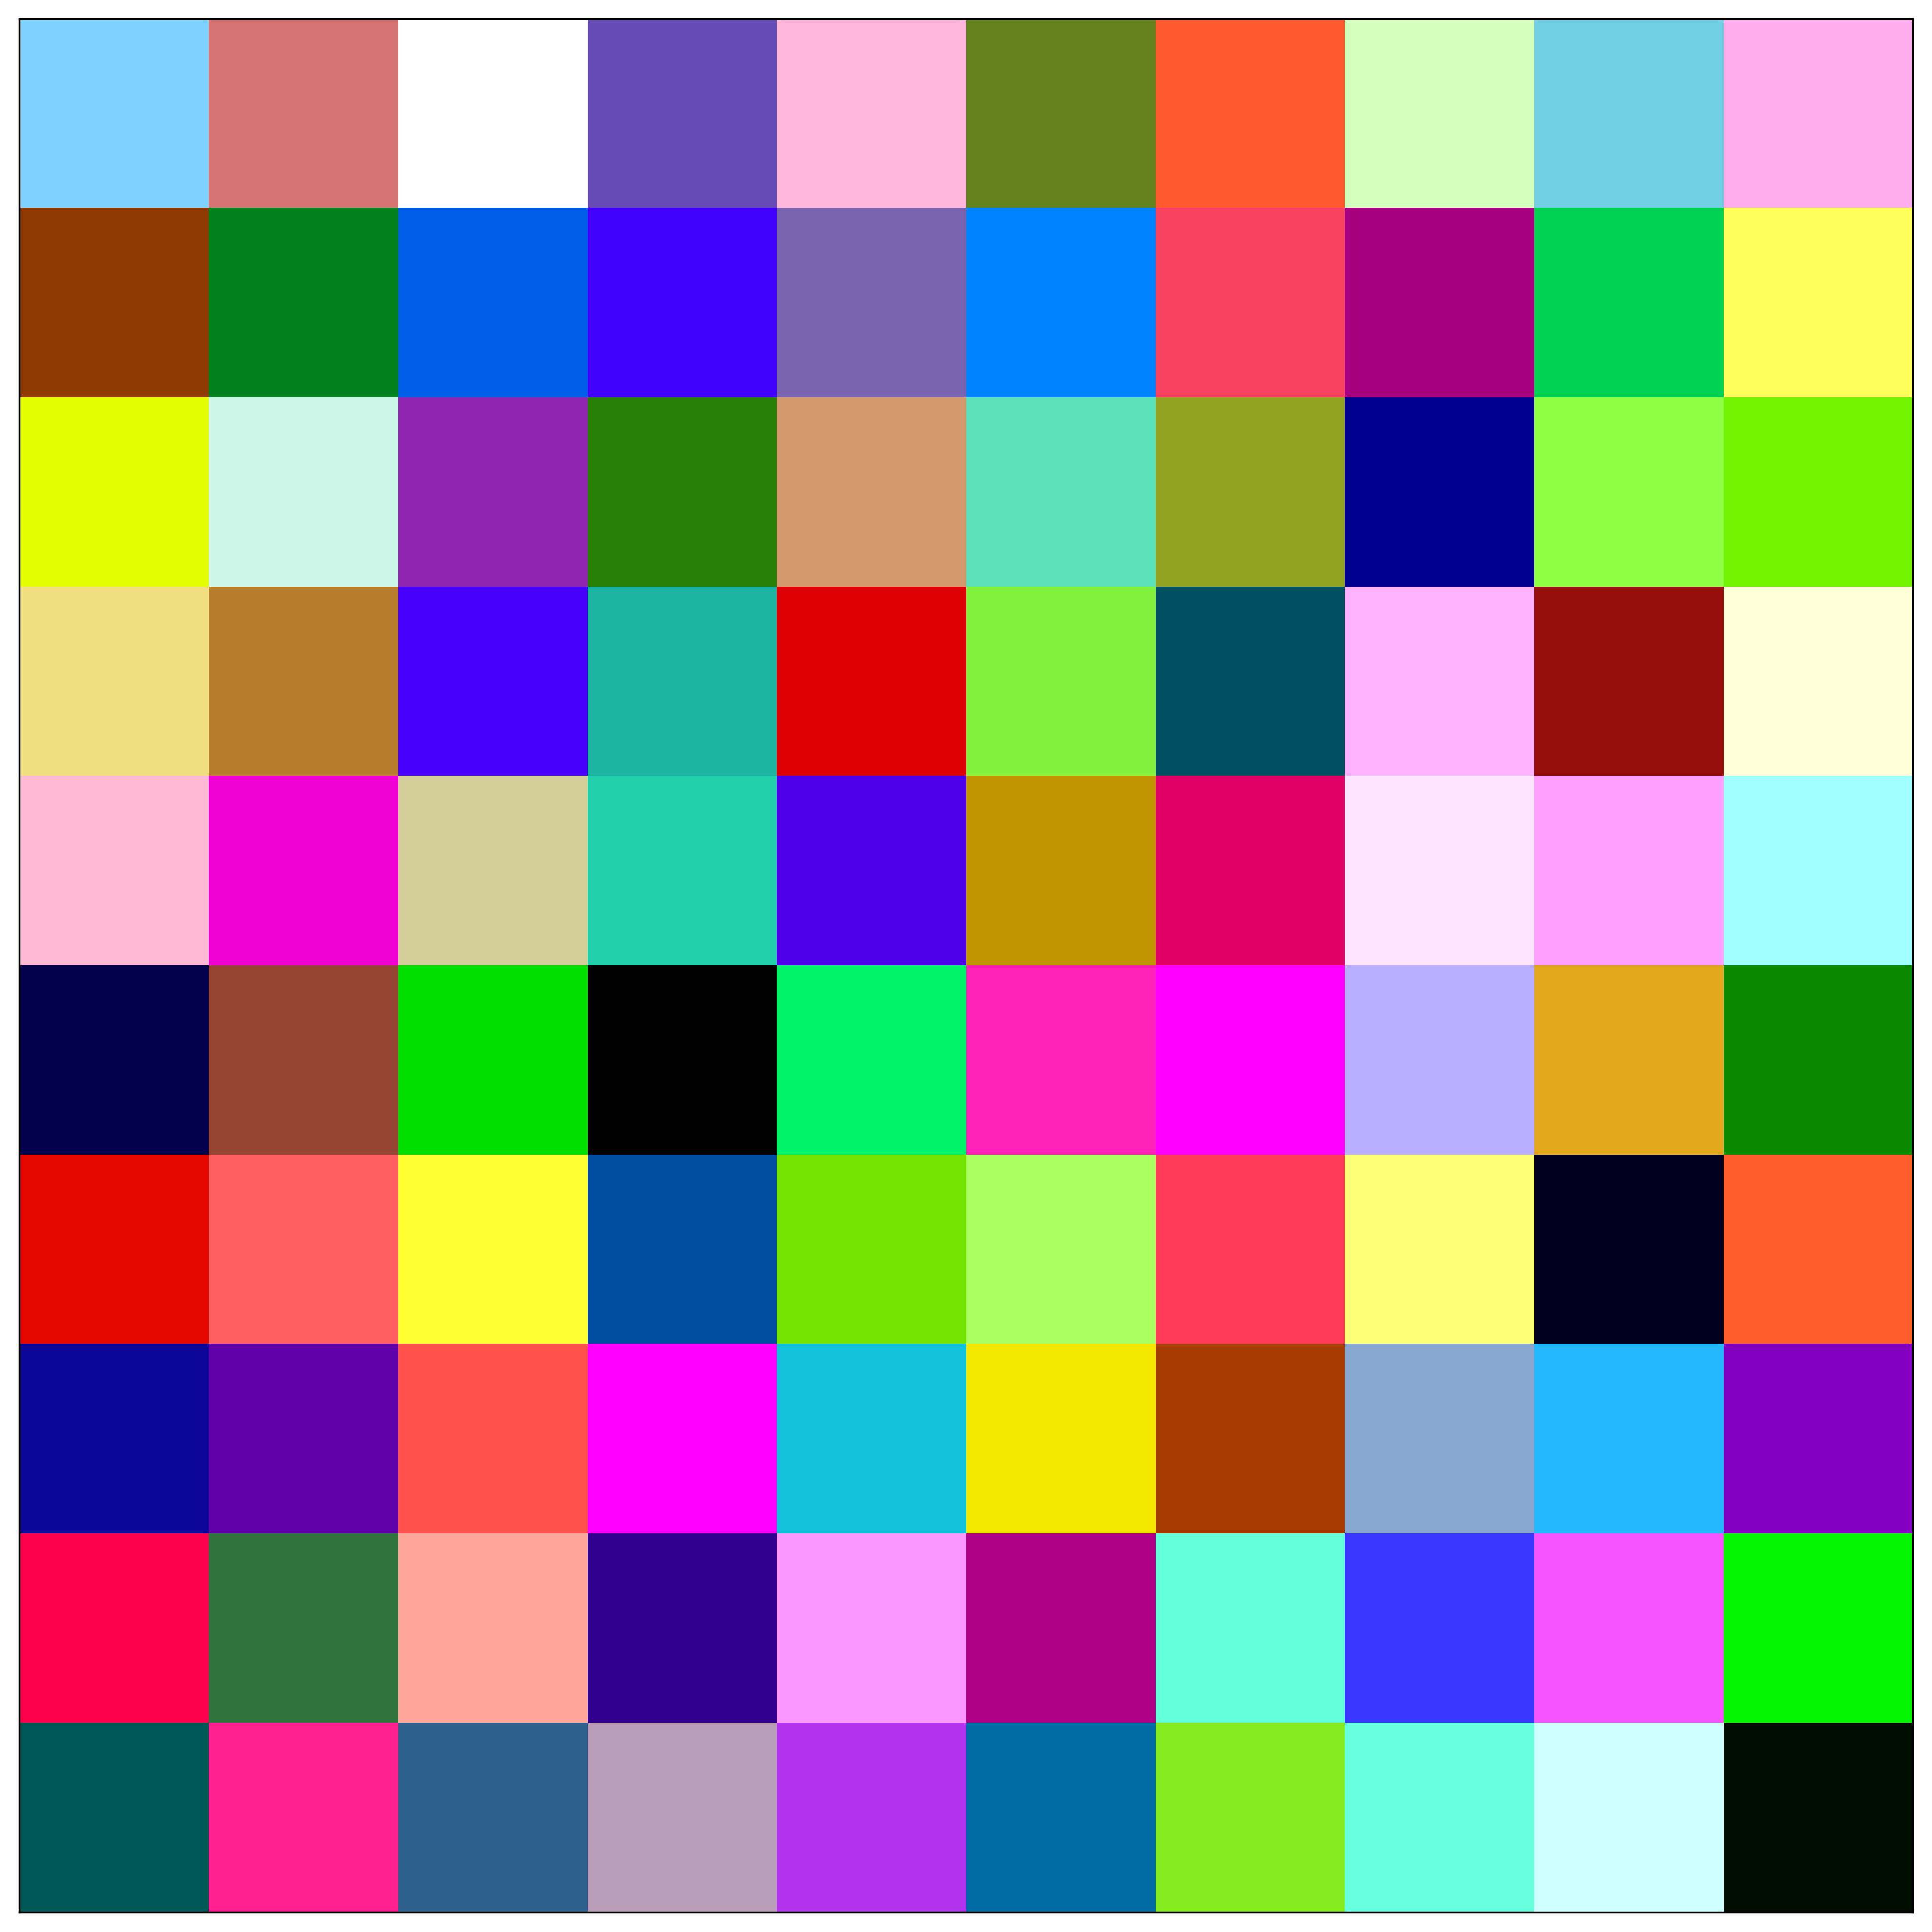

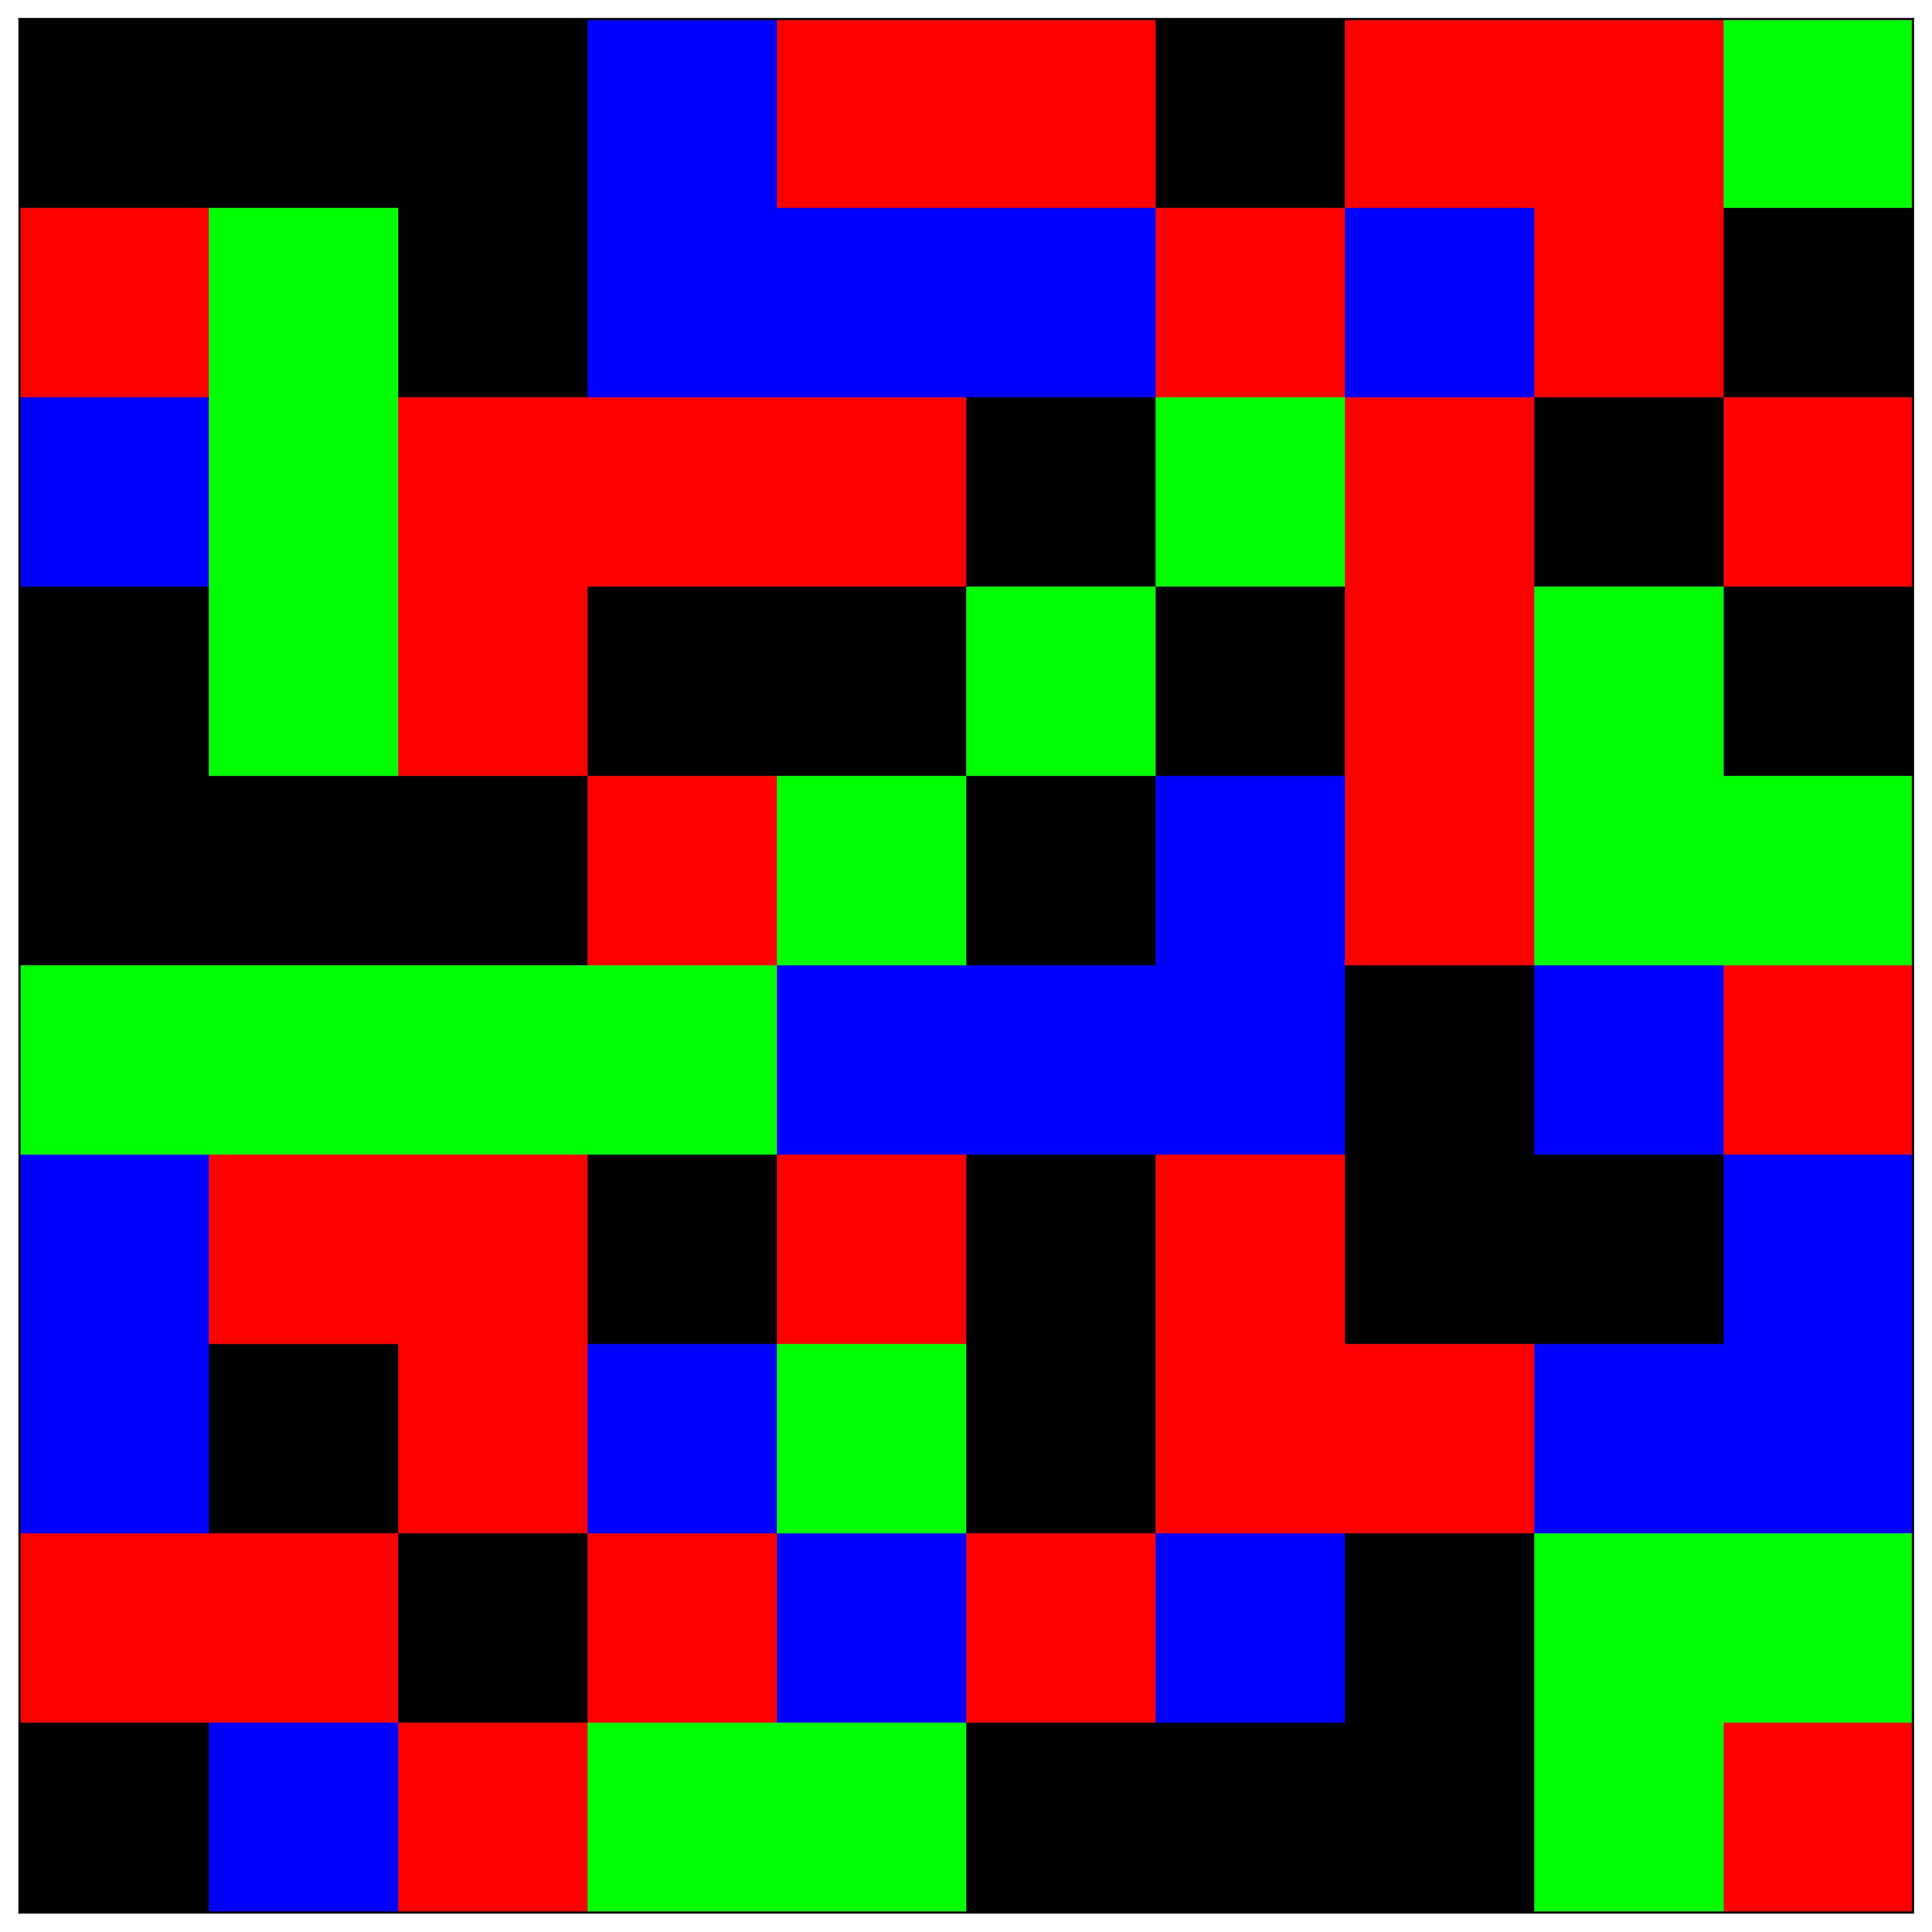

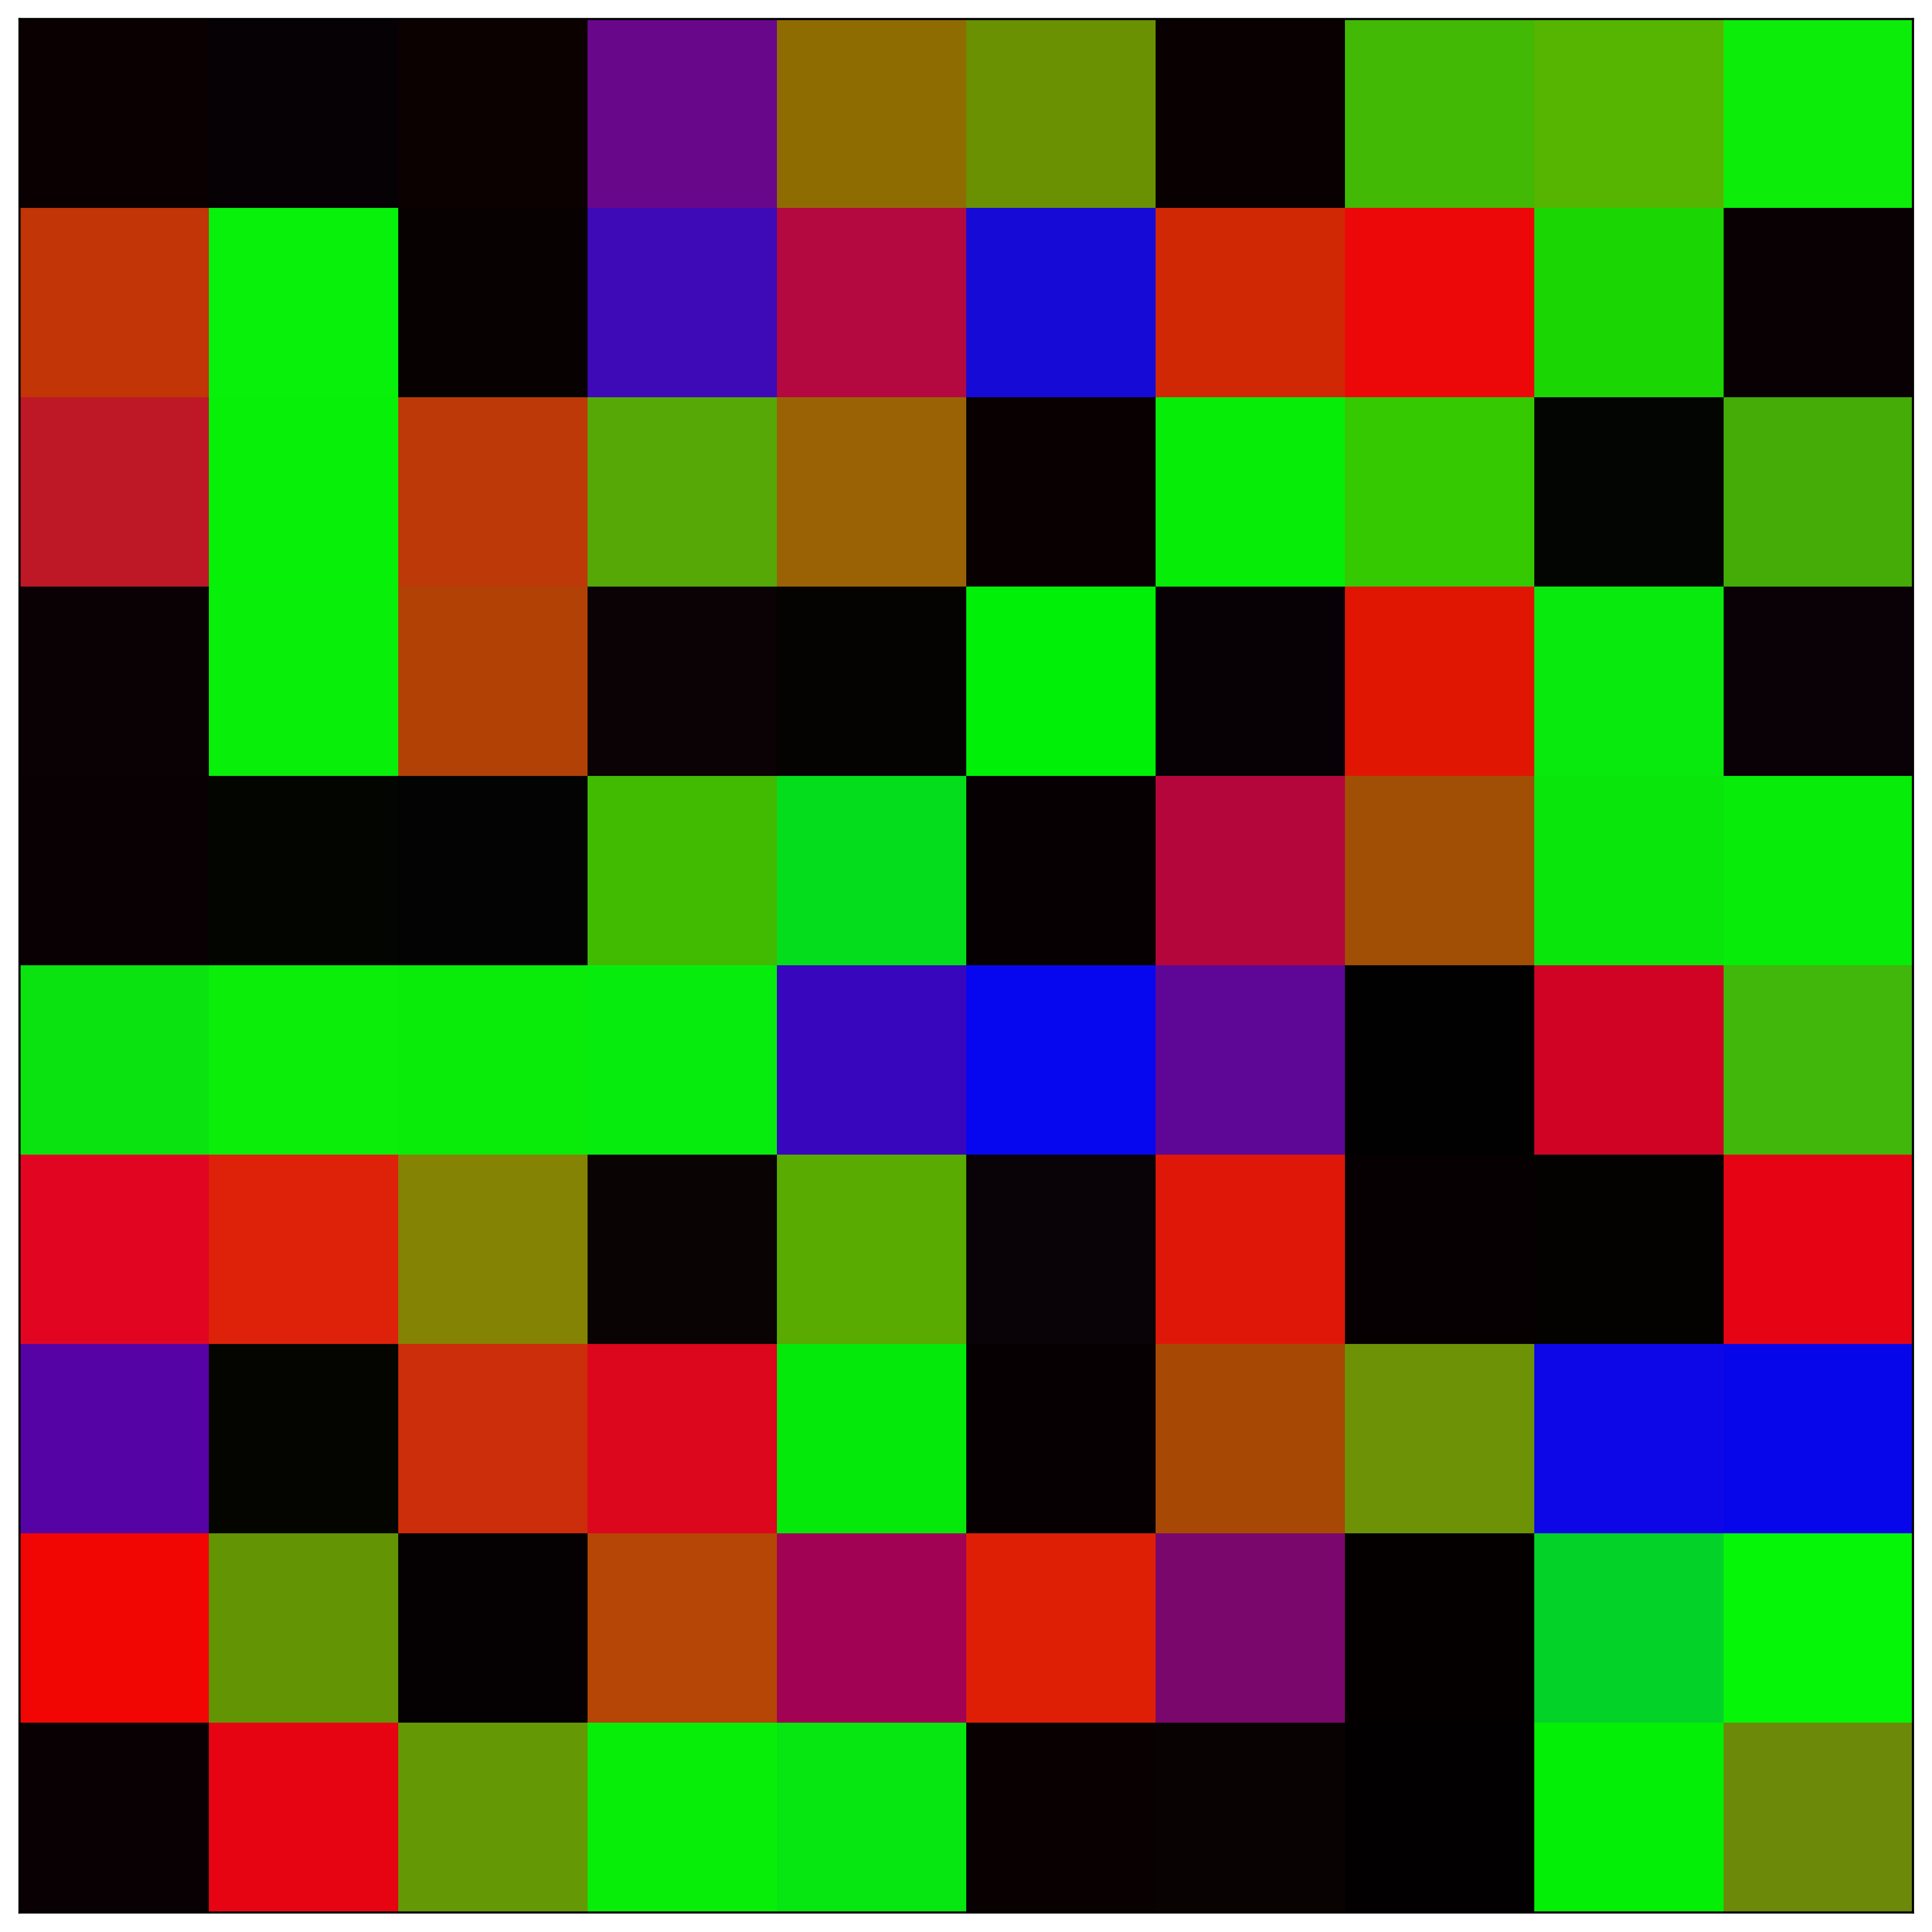

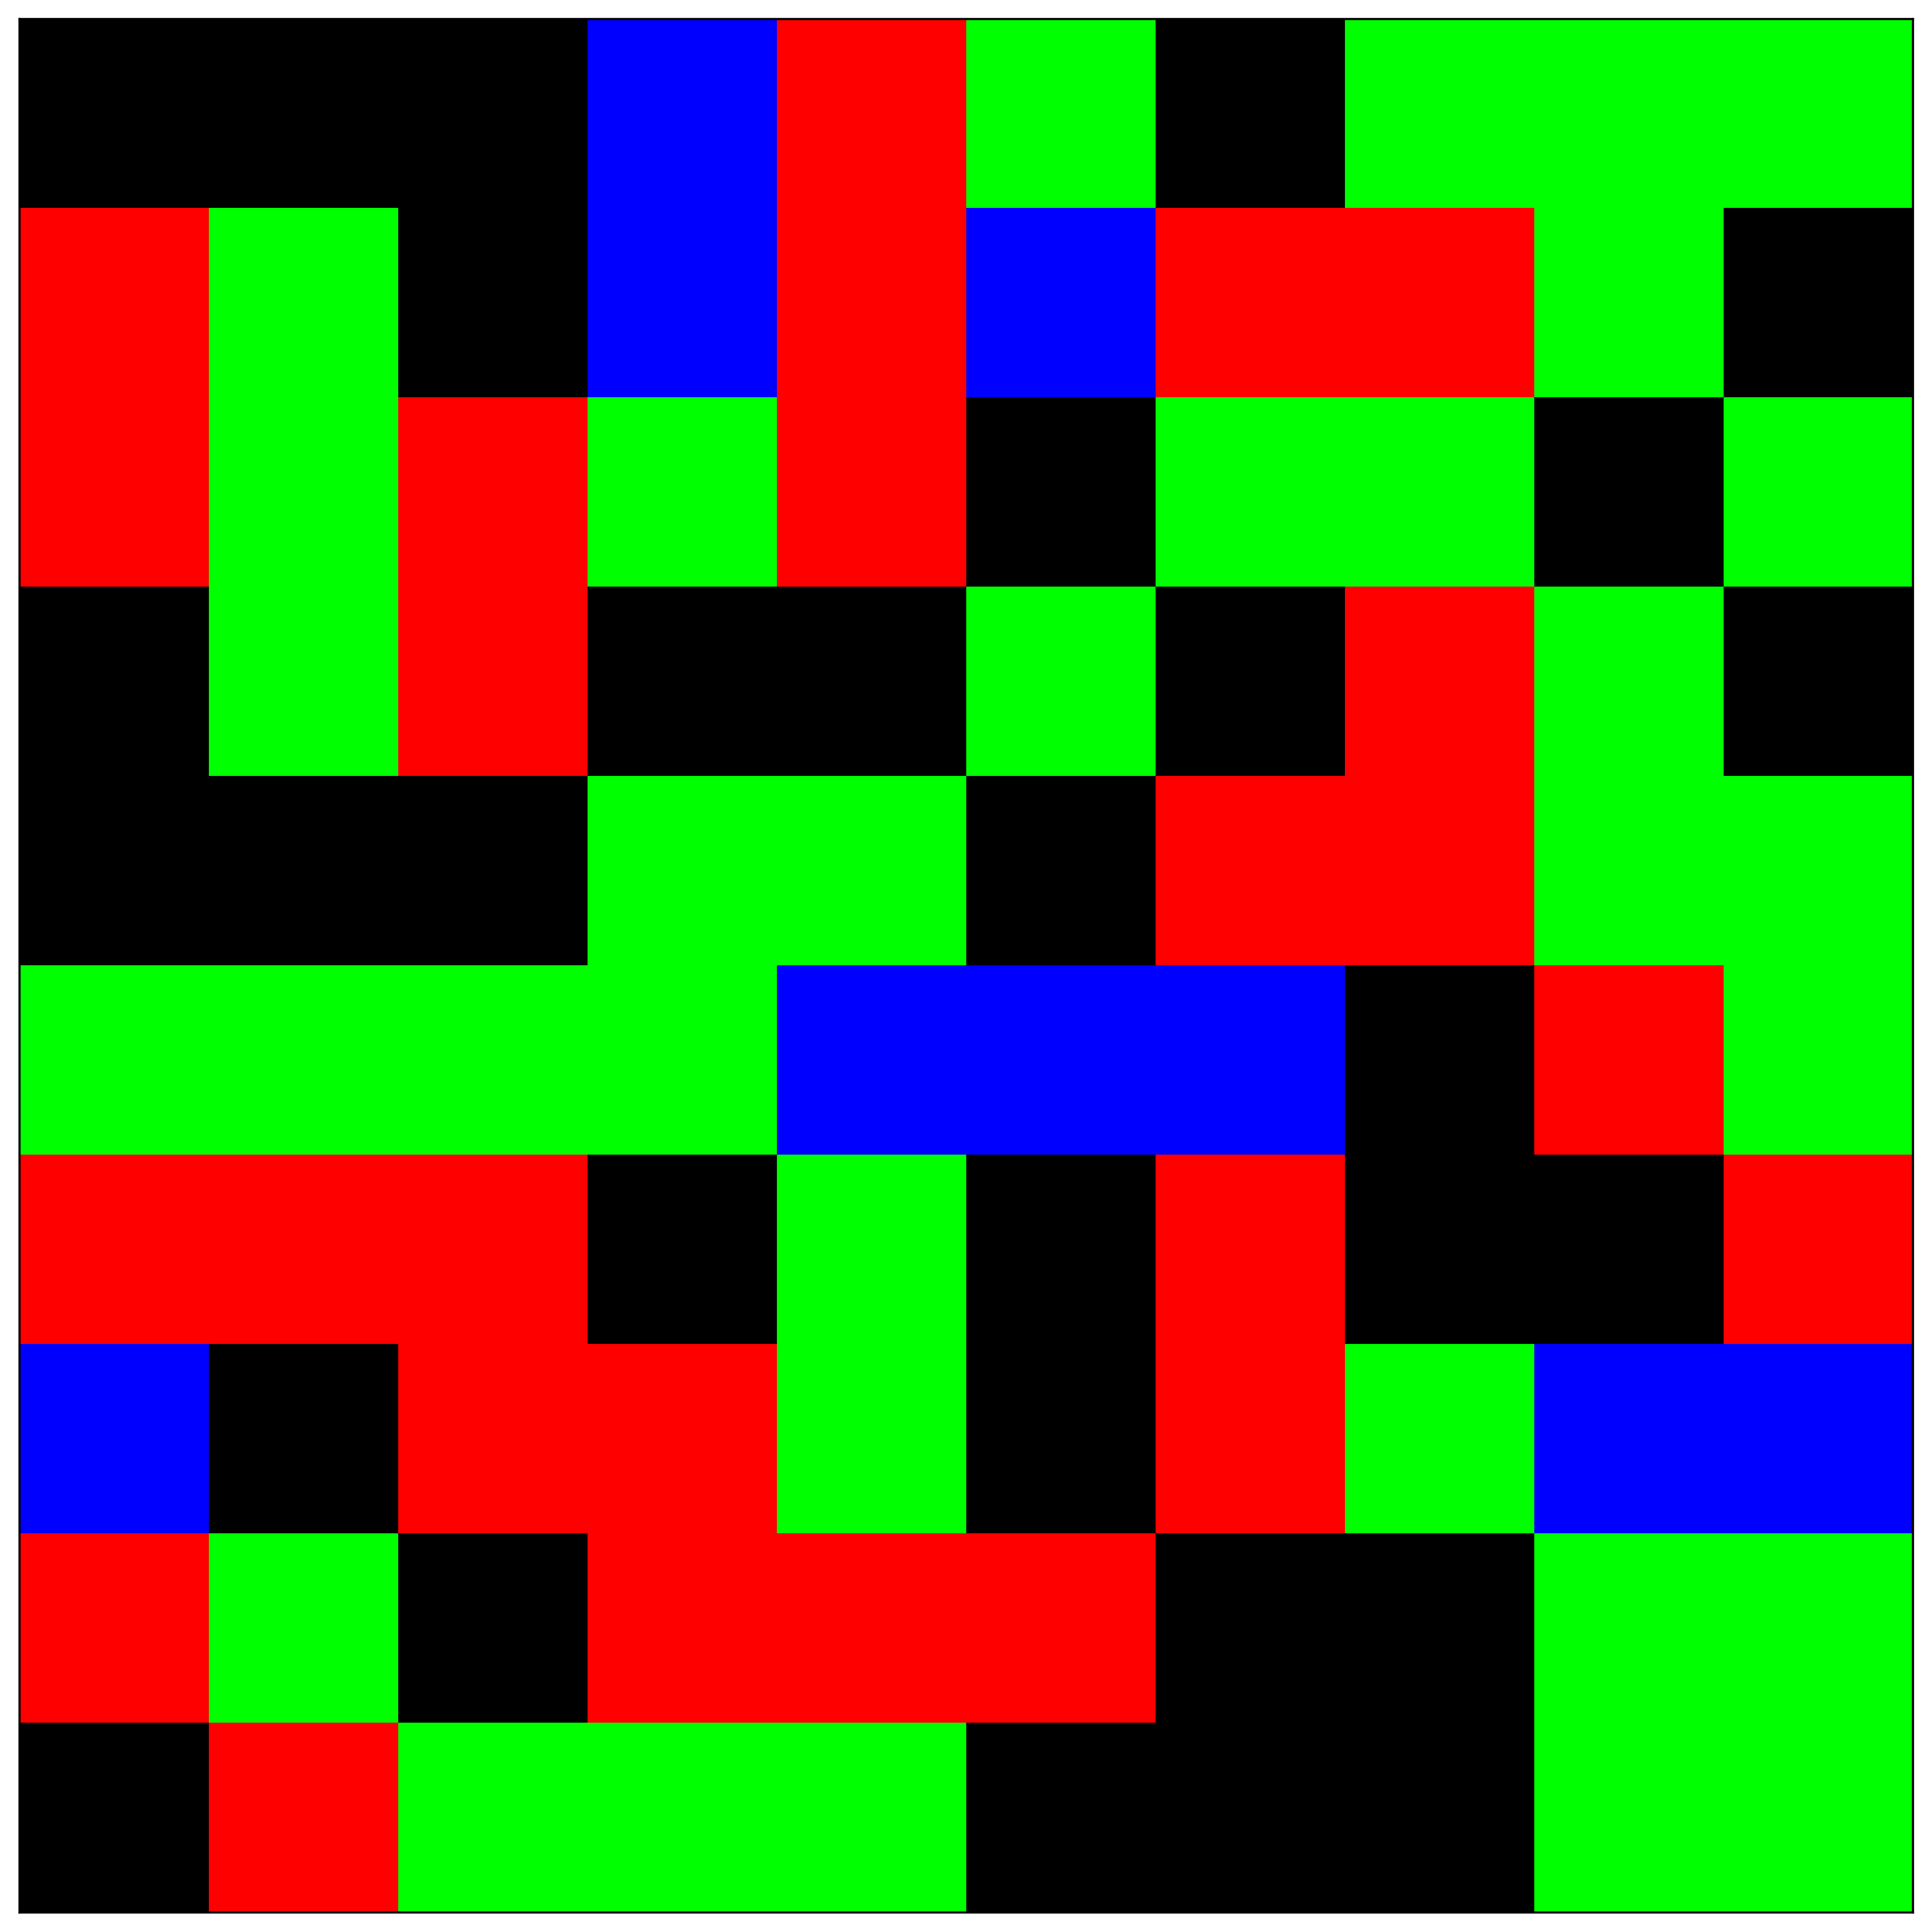

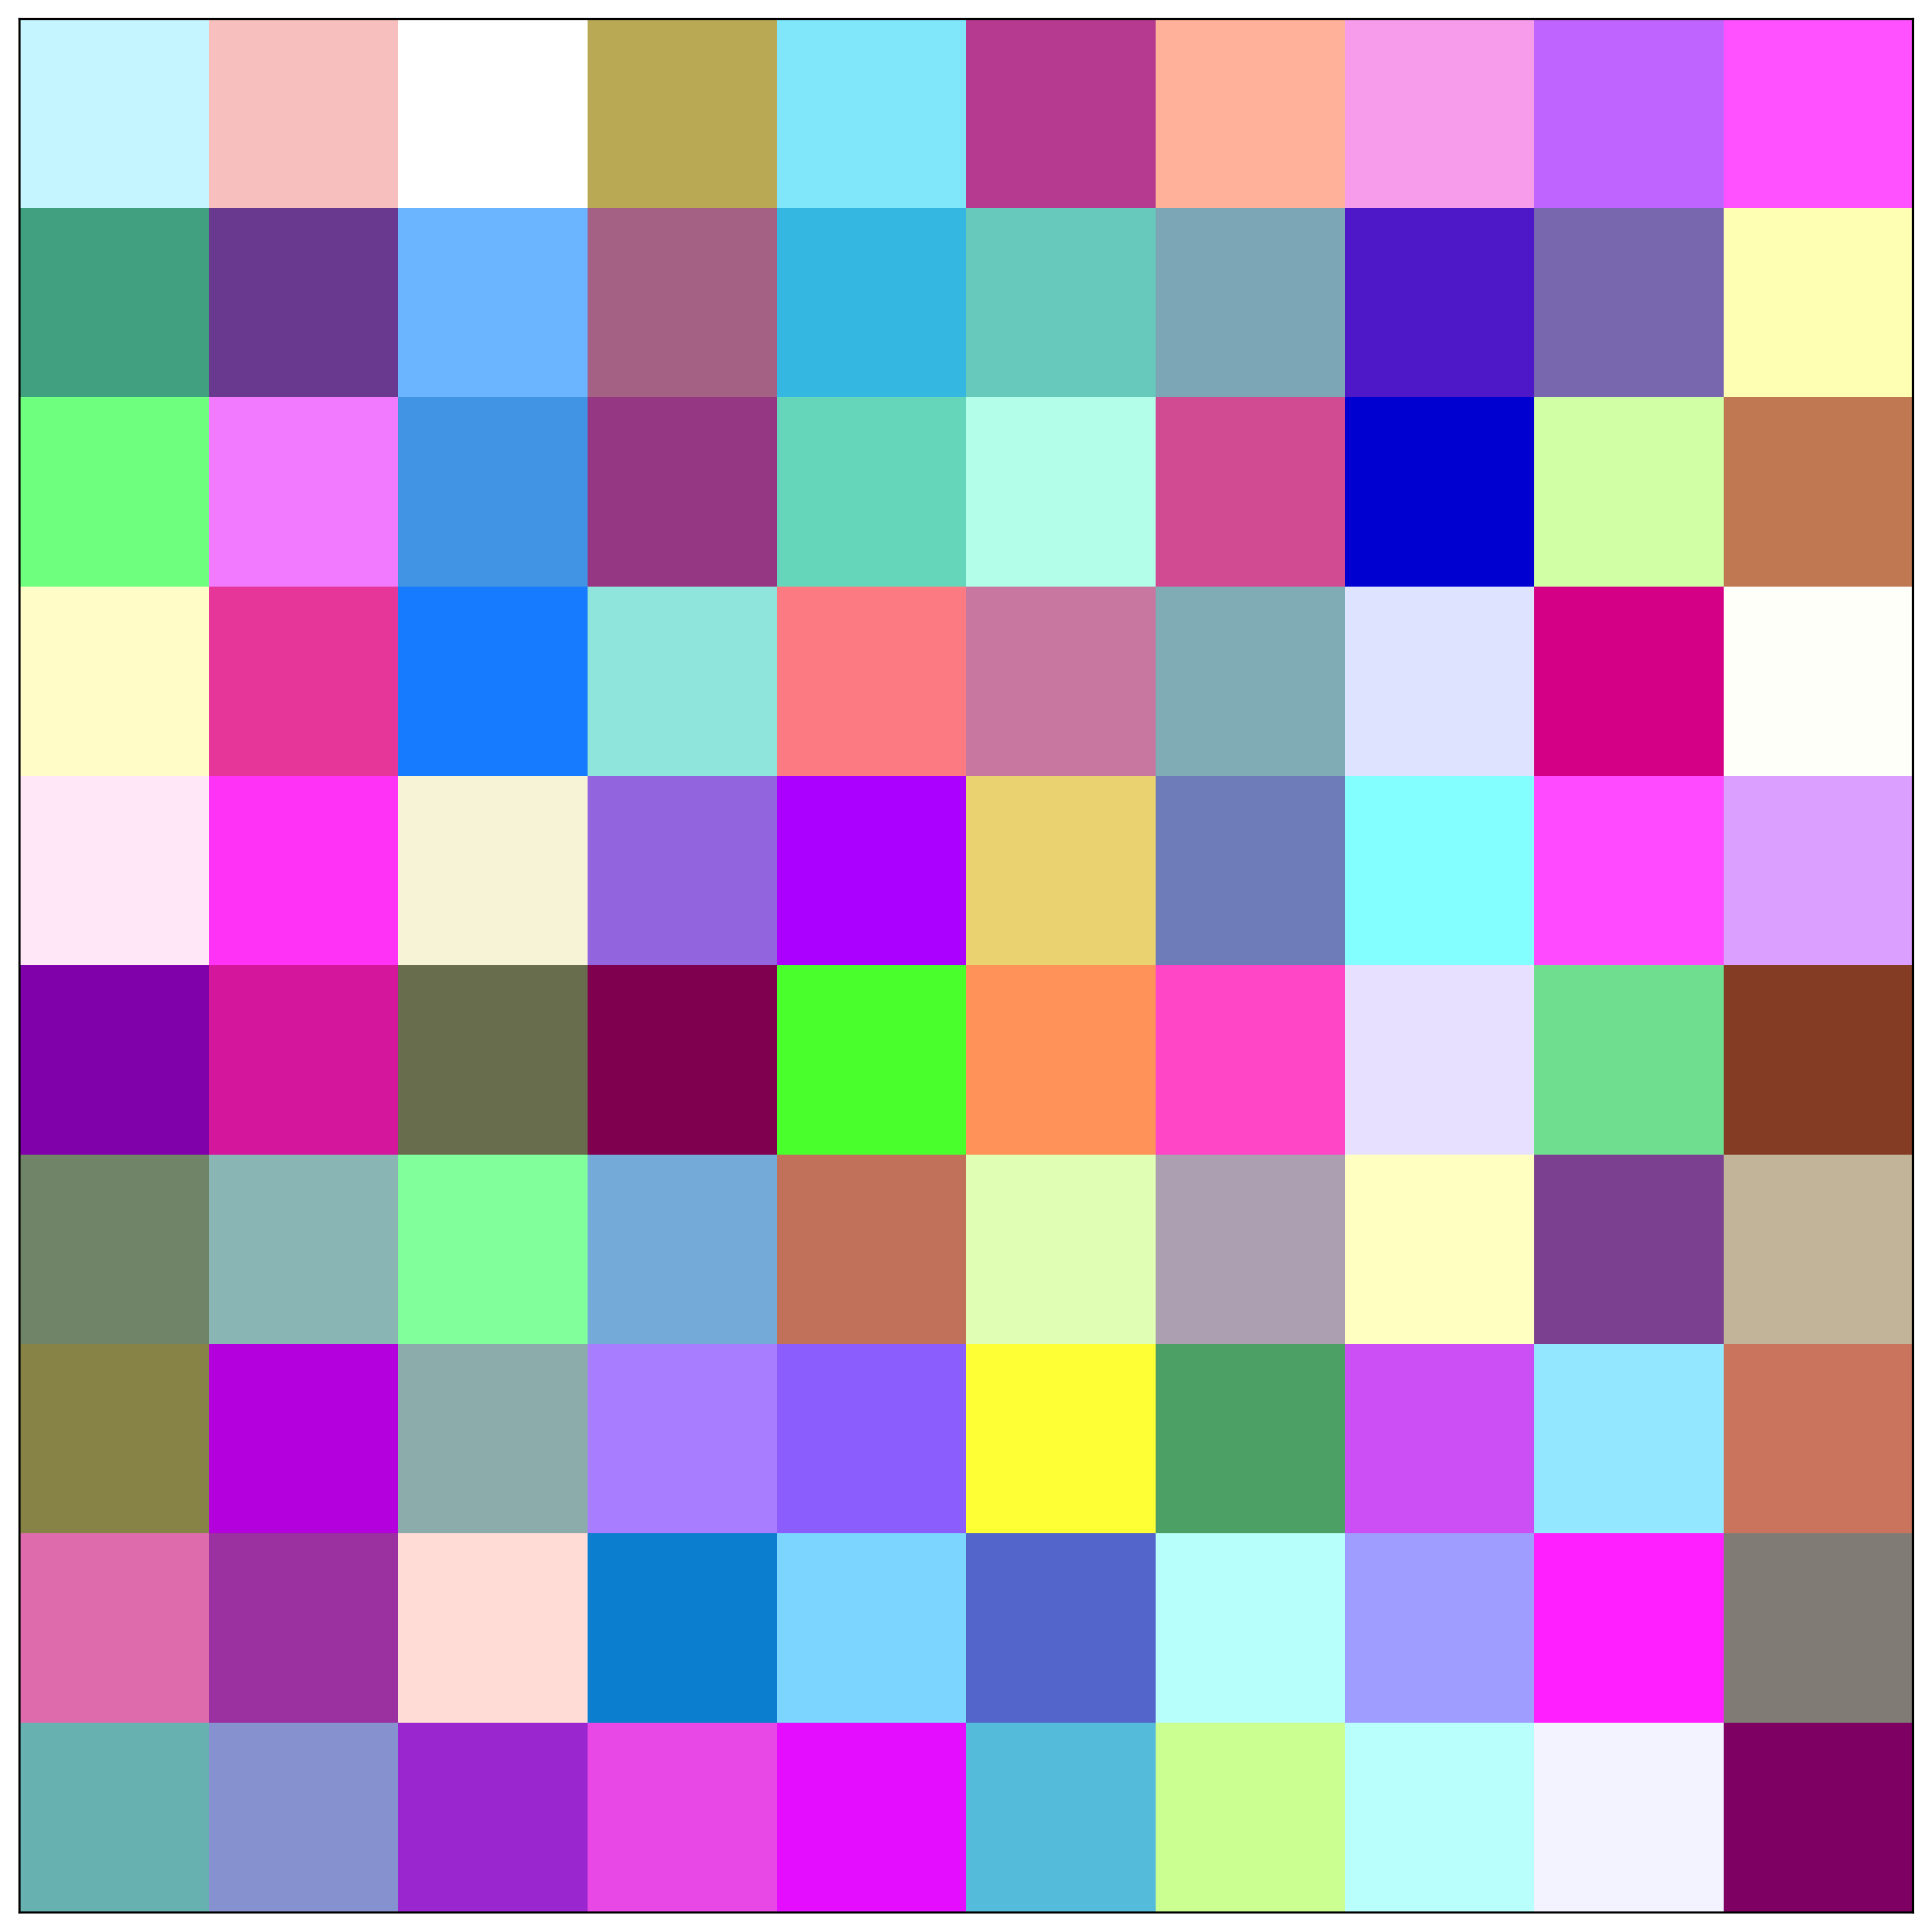

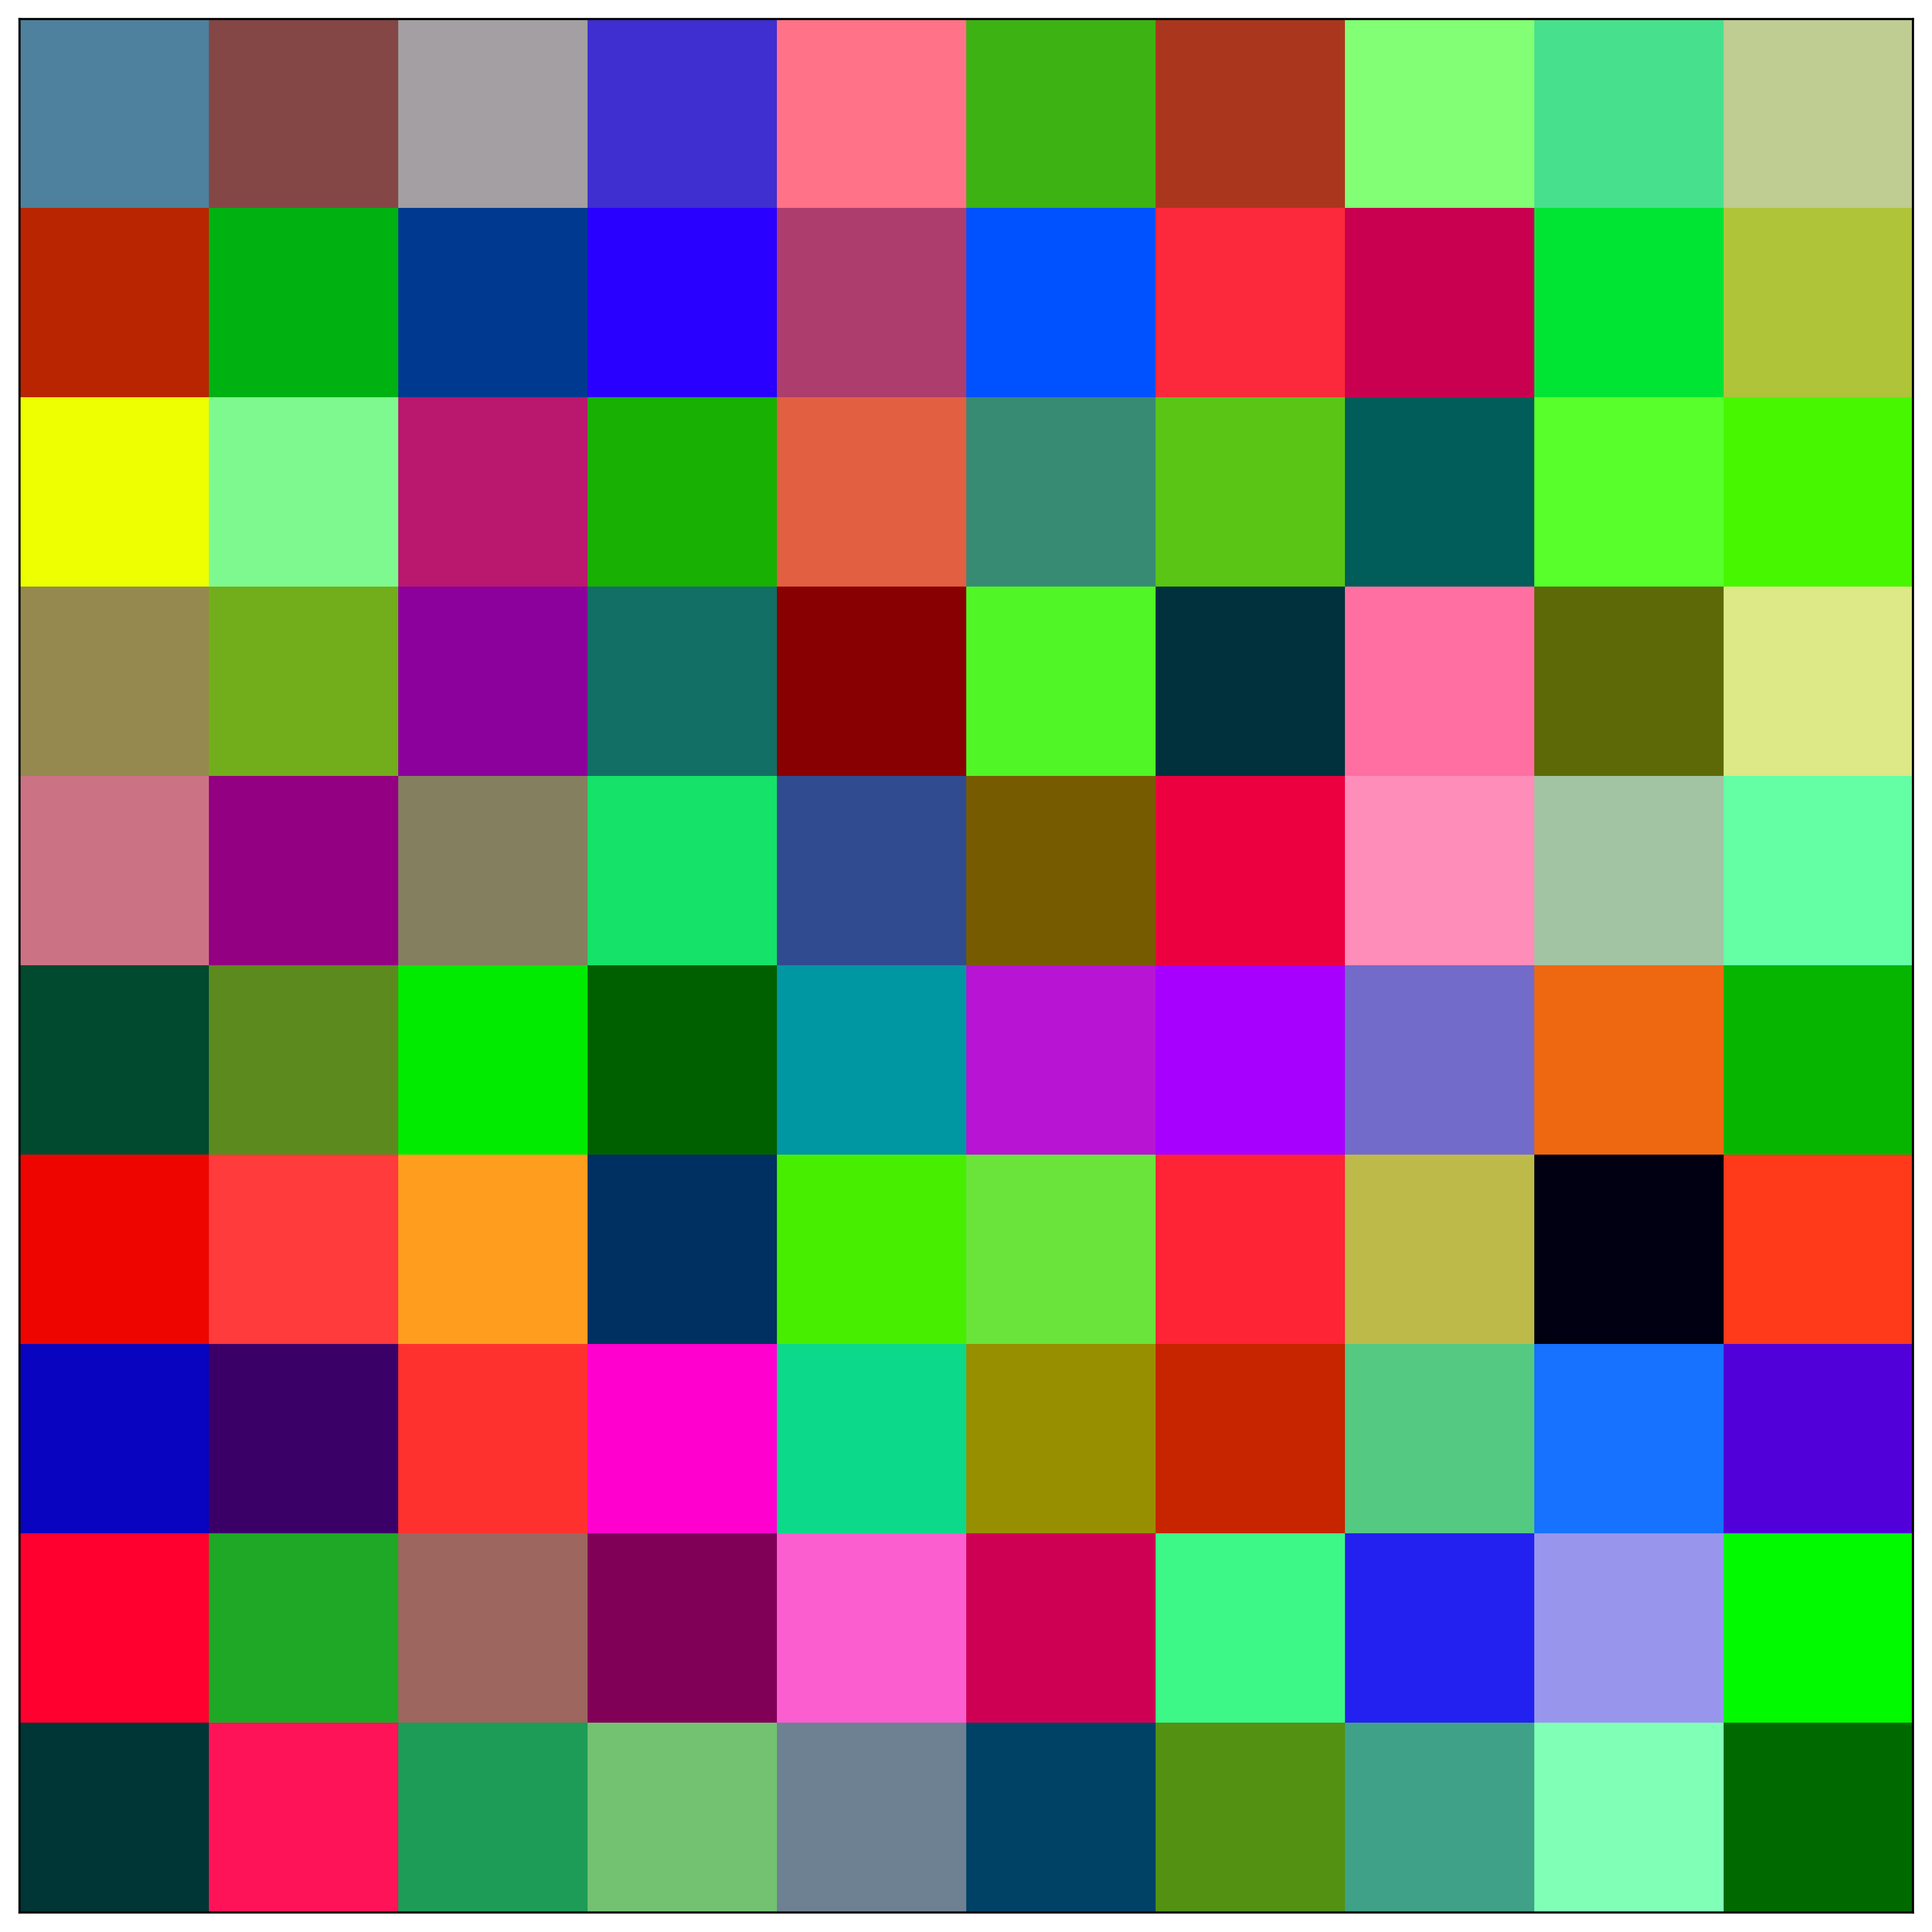

In [71]:

P_INF = 0.5
P_REC = 0.4
P_WANE = 0.01
TOTAL_POPULATION = 0.7



gt_samples=(
        map_batch_grid_series_to_rgb(abm(
            jax.random.split(jax.random.key(69),2),
            10,
            20,
            P_INF,
            P_REC,
            P_WANE,
            0.0,
            calc_start_n_initial(TOTAL_POPULATION,10),
            calc_start_n_initial(0.3, 10),
            calc_start_n_initial(0.2, 10),
        ))
        .reshape(2, 21, 10, 10, 3)
    )
obs = 2*gt_samples[0:1,:NUM_STEPS_CONDITIONING,...]-1
noise_key = jax.random.key(1337)
gamma_ = 2**0.5 - 1
x=jax.random.normal(noise_key, (1,10,10,3))

fig,ax = plt.subplots(figsize=(10,10),dpi=400)
ax.imshow((x[0]+1)/2)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.tight_layout()
fig.savefig('../06_08_viz/prev_x.svg')
plt.show()

for sigma, next_sigma in zip(diff_sampler.sigmas[:-1], diff_sampler.sigmas[1:]):
    sigma_hat = sigma*(gamma_+1)
    
    fig,ax = plt.subplots(figsize=(10,10),dpi=400)
    ax.imshow((obs[0][0]+1)/2)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.tight_layout()
    fig.savefig('../06_08_viz/cond_obs.svg')
    plt.show()


    unsnapped_denoised = denoiser.denoise(x, sigma, 
                                obs[0], jnp.tile(jnp.array([P_INF, P_REC, P_WANE, TOTAL_POPULATION]), (1, 1)))

    fig,ax = plt.subplots(figsize=(10,10),dpi=400)
    ax.imshow(((unsnapped_denoised[0]+1)/2).astype(jnp.float32))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.tight_layout()
    fig.savefig('../06_08_viz/unsnapped_denoised.svg')
    plt.show()

    denoised = 2*map_image_to_palette((unsnapped_denoised+1)/2, rgb_colours)-1

    fig,ax = plt.subplots(figsize=(10,10),dpi=400)
    ax.imshow(((denoised[0]+1)/2).astype(jnp.float32))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.tight_layout()
    fig.savefig('../06_08_viz/snapped_denoised.svg')
    plt.show()



    d= (x-denoised)/sigma_hat
    fig,ax = plt.subplots(figsize=(10,10),dpi=400)
    ax.imshow(((d[0]+1)/2).astype(jnp.float32))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.tight_layout()
    fig.savefig('../06_08_viz/difference.svg')
    plt.show()

    dt = next_sigma - sigma_hat
    x = x + d * dt
    fig,ax = plt.subplots(figsize=(10,10),dpi=400)
    ax.imshow(((x[0]+1)/2).astype(jnp.float32))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.tight_layout()
    fig.savefig('../06_08_viz/next_x.svg')
    plt.show()
    break

## Load for other figs

In [3]:
NUM_STEPS_CONDITIONING=1
NUM_STEPS_DENOISING=3
SNAP_AFTER_DIFFUSION=True
SNAP_DURING_DIFFUSION=True



den_cfg = DenoiserConfig(
    {
        "img_channels": 3,
        "num_steps_conditioning": NUM_STEPS_CONDITIONING,#4,
        "cond_channels": 256,
        "depths": [2,2,2,2],#[2, 2, 2, 2],
        "channels": [64,64,64,64],#[64, 64, 64, 64],
        "attn_depths": [0,0,0,0],#[0, 0, 0, 0],
        "num_abm_params": 4,
        "static_h": 10,
        "static_w": 10,
    },
    0.7, #0.9
    0.3,
)
#Trained on 20
denoiser = Denoiser(den_cfg, rgb_palette=rgb_colours if SNAP_DURING_DIFFUSION else None,rngs=nnx.Rngs(0))
sigma_dist_conf = SigmaDistributionConfig(-0.4, 1.2, 2e-3, 20)
denoiser.setup_training(sigma_dist_conf)

_, abstract_model = nnx.state(denoiser, nnx.RngState, ...)


checkpointer = CheckPointer('no_move_diff_model') #'num_cond_1_auto_reg_5_snap_train_t4'
#Hack to get older model to load
restored_data = checkpointer.restore(checkpointer.get_latest(),abstract_state=abstract_model)#{'inner_model':abstract_model['inner_model']})

#denoiser.rgb_palette=nnx.Variable(rgb_colours)
nnx.update(denoiser, restored_data['state'])




diff_sampler_conf = DiffusionSamplerConfig(num_steps_denoising=NUM_STEPS_DENOISING,realisation_length=201, 
                                           snap_after_diffusion_palette=rgb_colours if SNAP_AFTER_DIFFUSION else None)
diff_sampler = DiffusionSampler(
    denoiser,
    diff_sampler_conf,
)
print(diff_sampler.denoiser.rgb_palette)

Variable( # 12 (48 B)
  value=Array([[0., 0., 0.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 1., 0.]], dtype=float32)
)


## Diffusion Time Visualisation

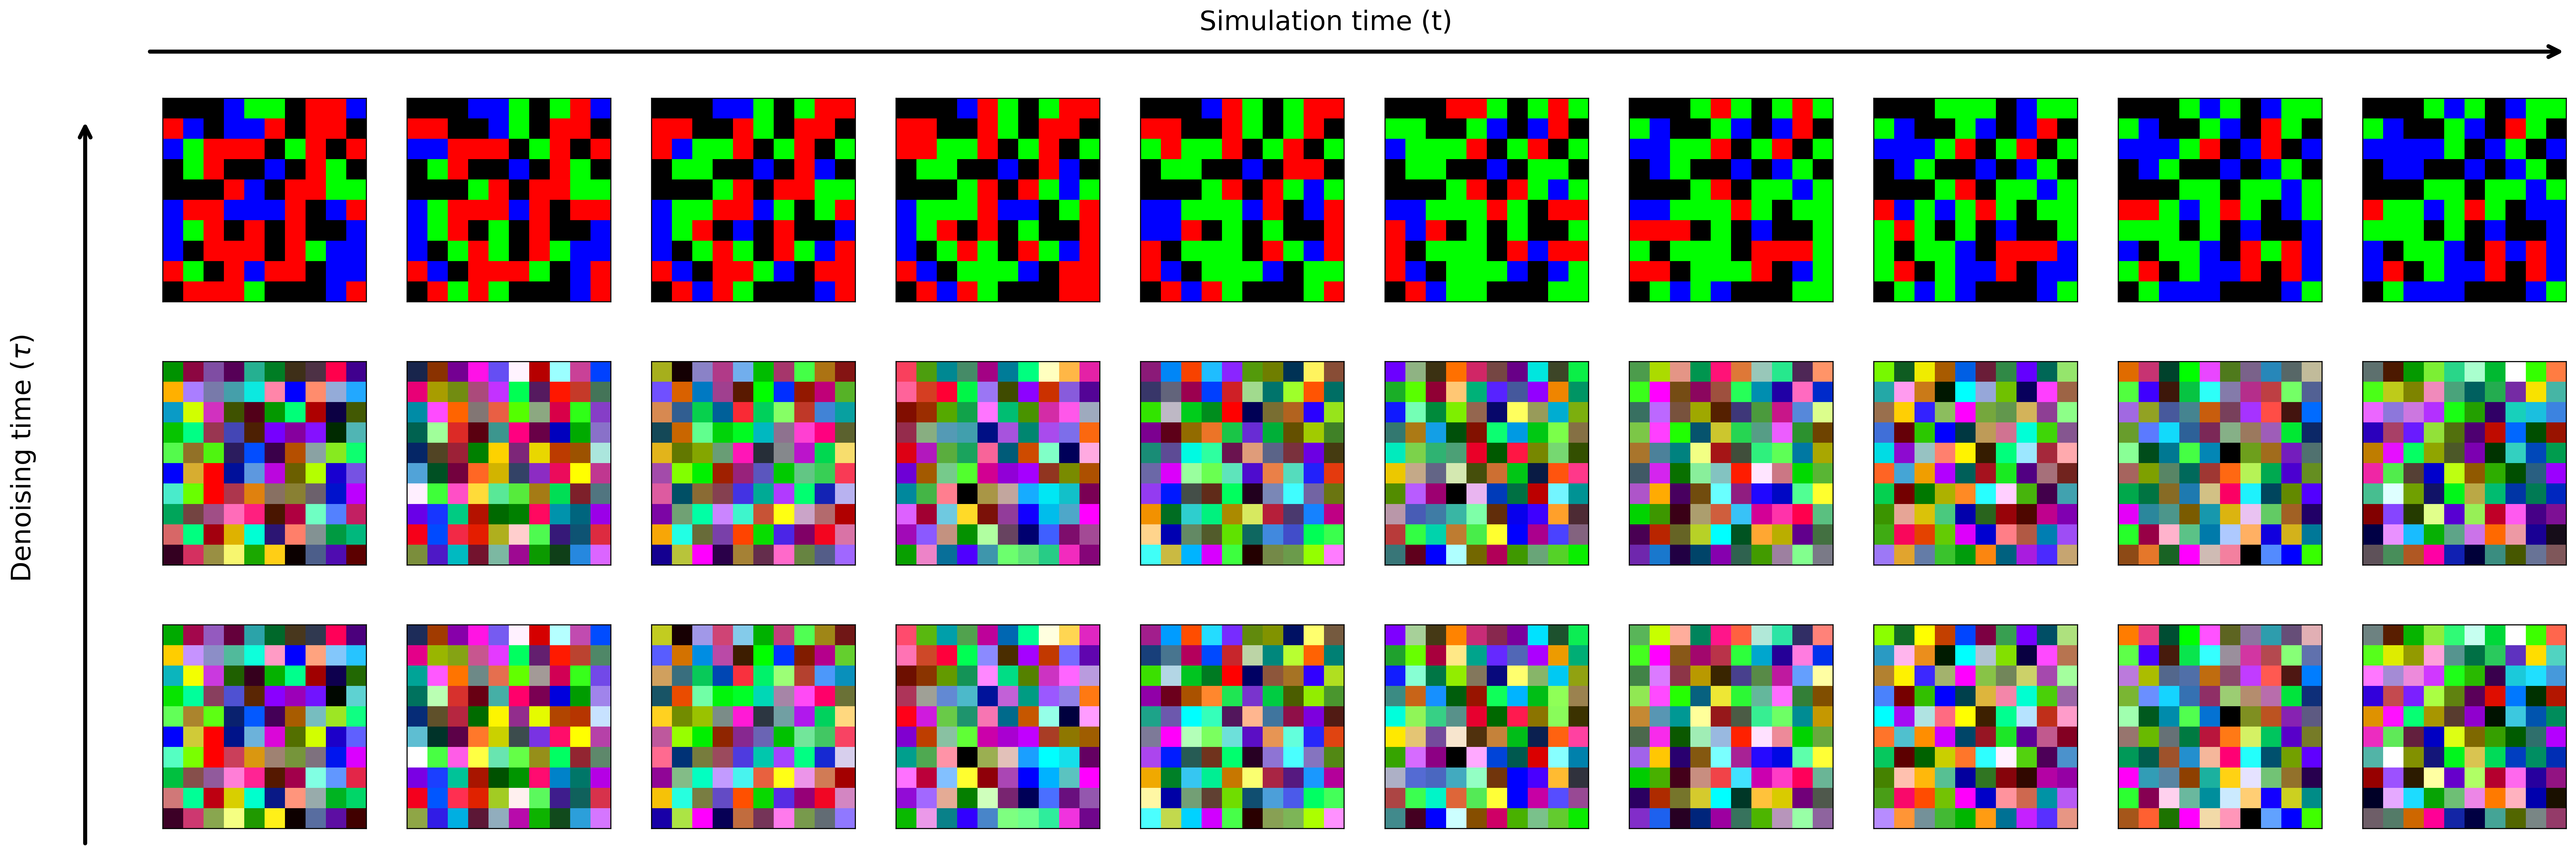

In [4]:
P_INF = 0.3
P_REC = 0.3
P_WANE = 0.2
TOTAL_POPULATION = 0.7


fig,axarr = plt.subplots(NUM_STEPS_DENOISING,10,figsize=(32,10),dpi=400)

gt_samples=(
        map_batch_grid_series_to_rgb(abm(
            jax.random.split(jax.random.key(69),2),
            10,
            20,
            P_INF,
            P_REC,
            P_WANE,
            0.0,
            calc_start_n_initial(TOTAL_POPULATION,10),
            calc_start_n_initial(0.3, 10),
            calc_start_n_initial(0.1, 10),
        ))
        .reshape(2, 21, 10, 10, 3)
    )

obs = gt_samples[0:1,:NUM_STEPS_CONDITIONING,...]
# for i in range(NUM_STEPS_CONDITIONING):
#     axarr[0,i].imshow(obs[0][i])
#     axarr[0,i].xaxis.set_visible(False)  # Hide the entire x-axis
#     axarr[0,i].yaxis.set_visible(False) # Optionally, hide the y-axis axarr[0,idx]
#     for j in range(1,NUM_STEPS_DENOISING):
#         axarr[j,i].imshow(jnp.zeros((10,10,3)))
#         axarr[j,i].xaxis.set_visible(False)  # Hide the entire x-axis
#         axarr[j,i].yaxis.set_visible(False) # Optionally, hide the y-axis

for idx in range(NUM_STEPS_CONDITIONING,11):
    sample, trajectory = diff_sampler.sample(
        jax.random.fold_in(jax.random.key(42),idx),
        2*obs-1, jnp.tile(jnp.array([P_INF, P_REC, P_WANE, TOTAL_POPULATION]), (1, 1)))
    # if SNAP_SAMPLE_AFTER_DIFF:
    #     sample = map_image_to_palette((sample[0]+1)/2, rgb_colours)
    # else:
    sample = (sample[0]+1)/2
    # axarr[0,idx].imshow(jnp.clip(sample,min=0,max=1))
    # axarr[0,idx].xaxis.set_visible(False)  # Hide the entire x-axis
    # axarr[0,idx].yaxis.set_visible(False) # Optionally, hide the y-axis axarr[0,idx]
    obs = jnp.roll(obs, -1, axis=1)
    obs = obs.at[:,NUM_STEPS_CONDITIONING-1,...].set(sample)
    for jdx, diff_intermediate in enumerate(reversed(trajectory)):
        axarr[jdx, idx-1].imshow(jnp.clip((diff_intermediate[0]+1)/2,min=0, max=1))
        axarr[jdx,idx-1].xaxis.set_visible(False)  # Hide the entire x-axis
        axarr[jdx,idx-1].yaxis.set_visible(False) # Optionally, hide the y-axis 
    #print(len(trajectory))


# --- 1. Add Overall Axis Labels using Figure Coordinates ---
# (0,0) is bottom-left, (1,1) is top-right of the entire figure window
fig.text(0.5, 0.95, 'Simulation time (t)', ha='center', va='center', fontsize=20)
fig.text(0.08, 0.5, 'Denoising time ($\\tau$)', ha='center', va='center', rotation='vertical', fontsize=20)

# Draw arrows to represent the axes
# Horizontal axis arrow
fig.add_artist(mpatches.FancyArrowPatch(
    (0.12, 0.92), (0.9, 0.92),
    arrowstyle='->', mutation_scale=20, color='black', lw=3
))
# Vertical axis arrow
fig.add_artist(mpatches.FancyArrowPatch(
    (0.1, 0.85), (0.1, 0.1),
    arrowstyle='<-', mutation_scale=20, color='black', lw=3
))


fig.savefig("../06_08_viz/diff_and_sim_time.pdf")

plt.show()


## Diff Grid Trajectories

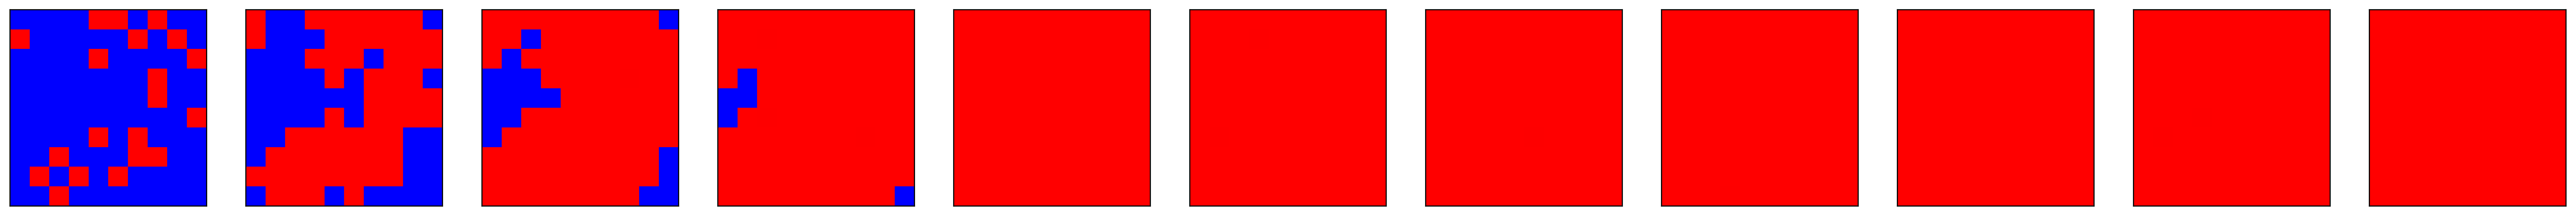

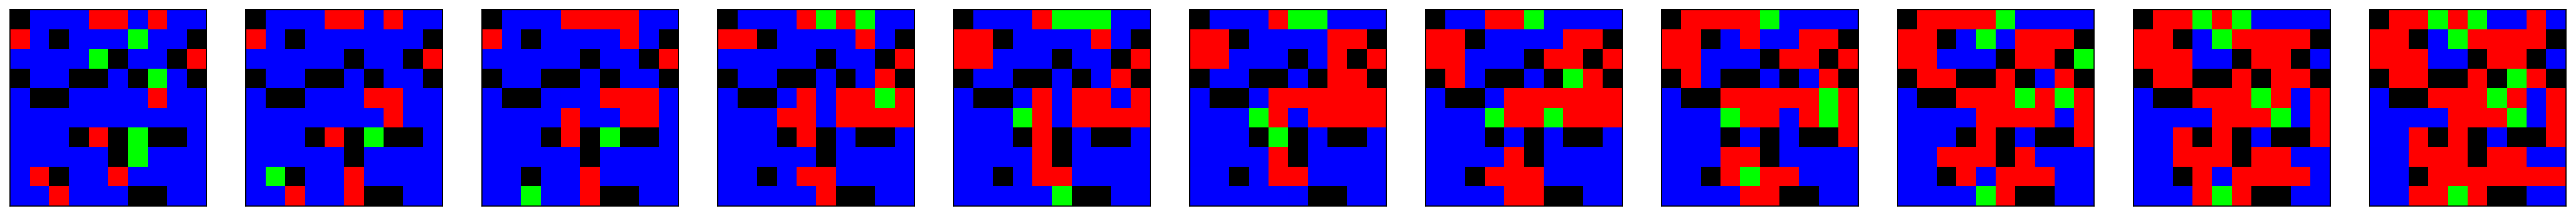

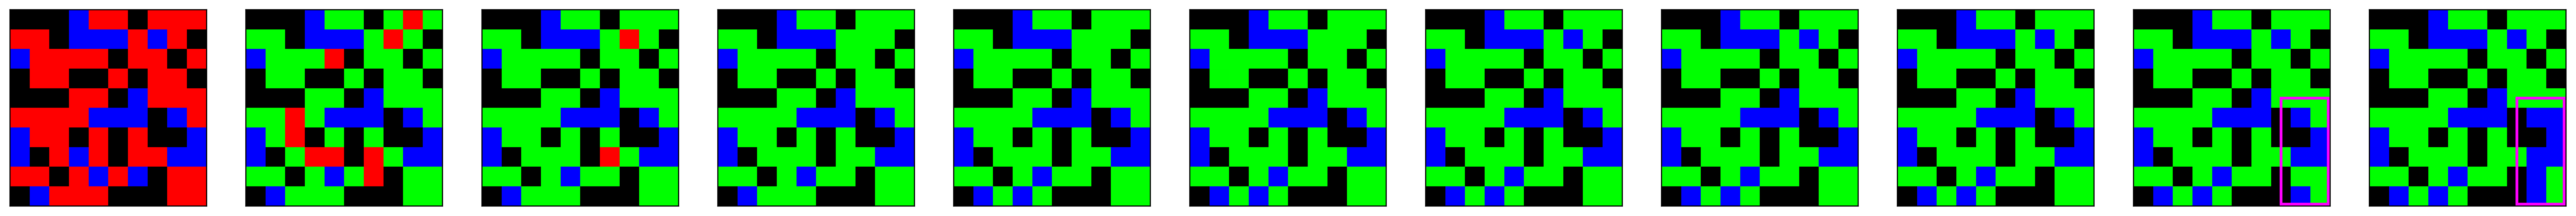

In [42]:

param_set1 = {'p_infect':0.8, 'p_recover':0.0, 'p_wane':0.0, 
              'total_population':1.0, 'initial_infected':0.2, 'initial_recovered':0.0}

param_set2={'p_infect':0.3, 'p_recover':0.15, 'p_wane':0.2, 
              'total_population':0.8, 'initial_infected':0.1, 'initial_recovered':0.05}

param_set3 = {'p_infect':0.1, 'p_recover':0.8, 'p_wane':0.00, 
              'total_population':0.7, 'initial_infected':0.5, 'initial_recovered':0.0}


for pdx,params in enumerate([param_set1,param_set2,param_set3]):

    fig,axarr = plt.subplots(1,11,figsize=(33,3),dpi=400)

    gt_samples=(
            map_batch_grid_series_to_rgb(abm(
                jax.random.split(jax.random.key(69),2),
                10,
                20,
                params['p_infect'],
                params['p_recover'],
                params['p_wane'],
                0.0,
                calc_start_n_initial(params['total_population'],10),
                calc_start_n_initial(params['initial_infected'], 10),
                calc_start_n_initial(params['initial_recovered'], 10),
            ))
            .reshape(2, 21, 10, 10, 3)
        )

    obs = gt_samples[0:1,:NUM_STEPS_CONDITIONING,...]
    axarr[0].imshow(obs[0][0])
    axarr[0].xaxis.set_visible(False)  # Hide the entire x-axis
    axarr[0].yaxis.set_visible(False) # Optionally, hide the y-axis 


    for idx in range(NUM_STEPS_CONDITIONING,11):
        sample, _ = diff_sampler.sample(
            jax.random.fold_in(jax.random.key(42),idx),
            2*obs-1, jnp.tile(jnp.array([params['p_infect'],
                params['p_recover'],
                params['p_wane'], params['total_population']]), (1, 1)))
        sample = (sample[0]+1)/2
        obs = jnp.roll(obs, -1, axis=1)
        obs = obs.at[:,NUM_STEPS_CONDITIONING-1,...].set(sample)
        axarr[idx].xaxis.set_visible(False)  # Hide the entire x-axis
        axarr[idx].yaxis.set_visible(False) # Optionally, hide the y-axis 
        axarr[idx].imshow(jnp.clip(sample,min=0, max=1))
        if pdx==2 and idx>=9:
            x, y, width, height = 7, 4, 2.4, 5.4

            # Create a Rectangle patch
            rect = mpatches.Rectangle(
                (x, y),
                width,
                height,
                linewidth=2,
                edgecolor='magenta',
                facecolor='none' # 'none' makes the rectangle transparent
            )

            # Add the patch to the Axes
            axarr[idx].add_patch(rect)
    fig.savefig(f'../06_08_viz/diff_grid_ex_{pdx}.pdf')
    plt.show()